In [1]:
pip install fredapi


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
<ipython-input-2-b6b57d399d35>:87: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-2-b6b57d399d35>:87: UserWarning: Glyph 129689 (\N{COIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-2-b6b57d399d35>:87: UserWarning: Glyph 127482 (\N{REGIONAL INDICATOR SYMBOL LETTER U}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-2-b6b57d399d35>:87: UserWarning: Glyph 127480 (\N{REGIONAL INDICATOR SYMBOL LETTER S}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-2-b6b57d399d35>:87: UserWarning: Glyph 127468 (\N{REGIONAL INDICATOR SYMBOL LETTER G}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-2-b6b57d399d35>:87: UserWarning: Glyph 127463 (\N{REGIONAL INDICATOR SYMBOL LETTER B}) missing from 

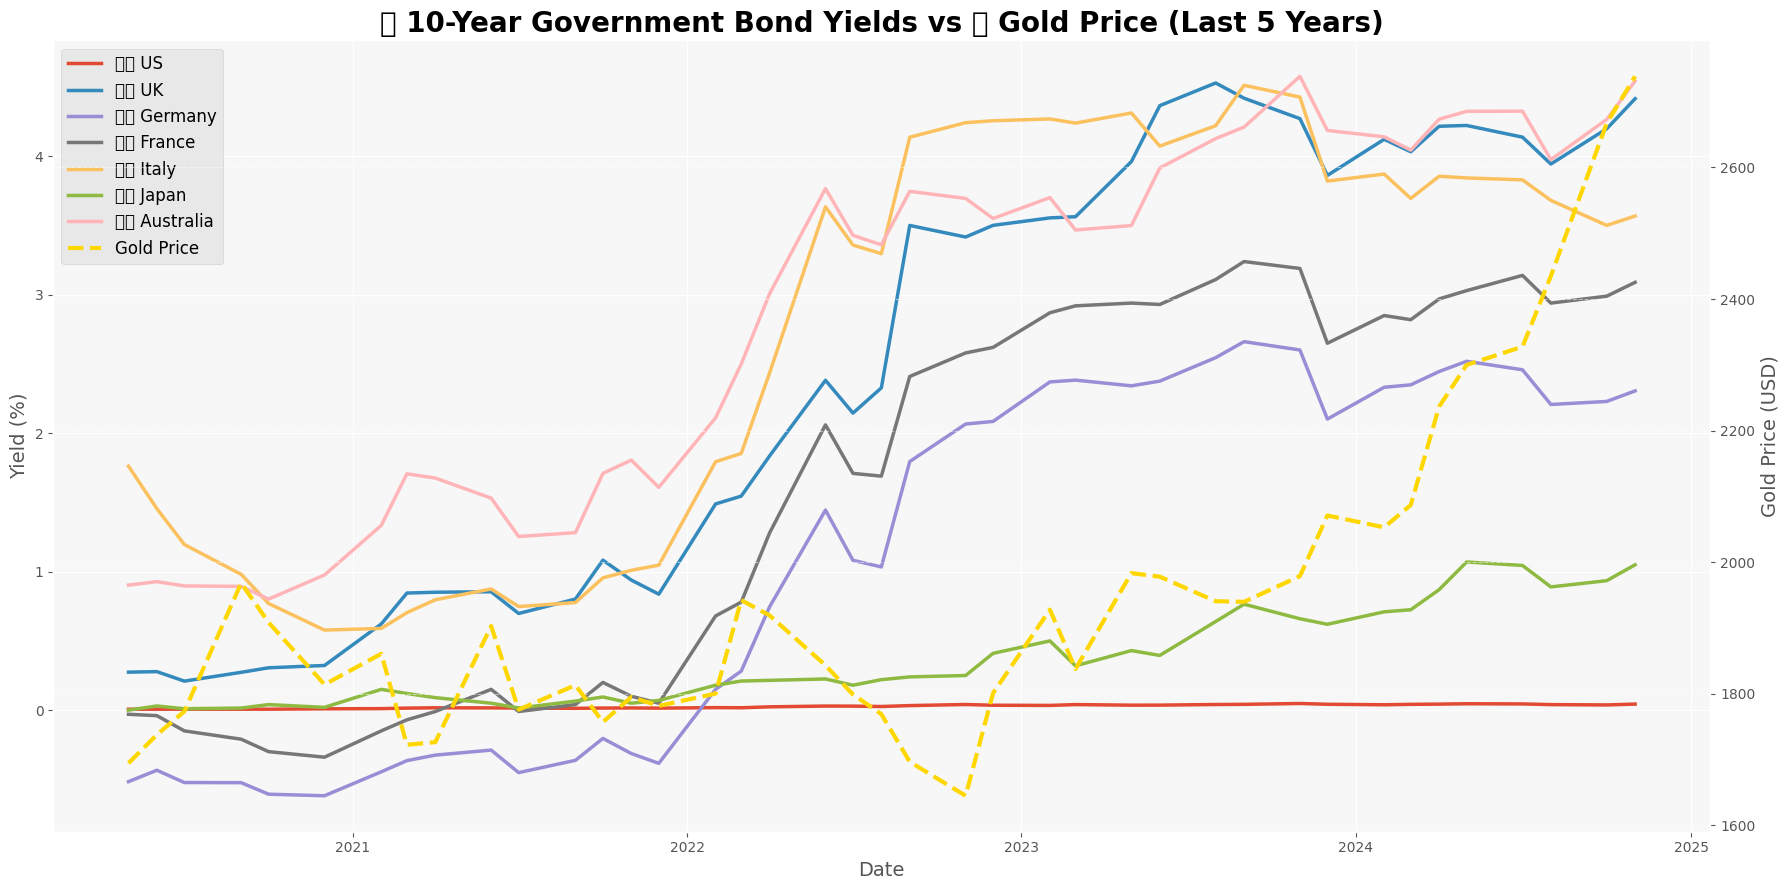

In [2]:
import yfinance as yf
from fredapi import Fred
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.dates as mdates

# Set date range: Last 5 years
end_date = datetime.today()
start_date = end_date - timedelta(days=5 * 365)

# US 10-Year Yield (^TNX from Yahoo)
us10y = yf.download("^TNX", start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))
us10y = us10y.reset_index()[['Date', 'Close']]
us10y.columns = ['Date', 'US_10Y_Yield']
us10y['US_10Y_Yield'] = us10y['US_10Y_Yield'] / 100  # Basis points to %

# FRED API key
fred = Fred(api_key='9f6b3c52c58b1abc1cfceed0a1417b9e')  # Replace with your valid key

# 10-Year Yields from FRED
country_series = {
    'UK_10Y_Yield': 'IRLTLT01GBM156N',
    'DE_10Y_Yield': 'IRLTLT01DEM156N',
    'FR_10Y_Yield': 'IRLTLT01FRM156N',
    'IT_10Y_Yield': 'IRLTLT01ITM156N',
    'JP_10Y_Yield': 'IRLTLT01JPM156N',
    'AU_10Y_Yield': 'IRLTLT01AUM156N'
}

# Fetch and format country yields
all_bonds = {}
for name, series_id in country_series.items():
    series = fred.get_series(series_id, observation_start=start_date)
    df_temp = series.reset_index()
    df_temp.columns = ['Date', name]
    all_bonds[name] = df_temp

# Merge all yields
df = us10y
for bond_df in all_bonds.values():
    df = pd.merge(df, bond_df, on='Date', how='inner')

# Get Gold Futures (GC=F)
gold = yf.download("GC=F", start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))
gold = gold.reset_index()[['Date', 'Close']]
gold.columns = ['Date', 'Gold_Price']
gold.dropna(inplace=True)

# Merge gold price
df = pd.merge(df, gold, on='Date', how='inner')

# Plotting
plt.style.use('ggplot')
fig, ax1 = plt.subplots(figsize=(18, 9))

# Primary Y-axis for bond yields
ax1.set_xlabel('Date', fontsize=14)
ax1.set_ylabel('Yield (%)', fontsize=14)
ax1.set_title('📉 10-Year Government Bond Yields vs 🪙 Gold Price (Last 5 Years)', fontsize=20, weight='bold')
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.set_facecolor('#f7f7f7')

# Bond yield plots
ax1.plot(df['Date'], df['US_10Y_Yield'], label='🇺🇸 US', linewidth=2.5)
ax1.plot(df['Date'], df['UK_10Y_Yield'], label='🇬🇧 UK', linewidth=2.5)
ax1.plot(df['Date'], df['DE_10Y_Yield'], label='🇩🇪 Germany', linewidth=2.5)
ax1.plot(df['Date'], df['FR_10Y_Yield'], label='🇫🇷 France', linewidth=2.5)
ax1.plot(df['Date'], df['IT_10Y_Yield'], label='🇮🇹 Italy', linewidth=2.5)
ax1.plot(df['Date'], df['JP_10Y_Yield'], label='🇯🇵 Japan', linewidth=2.5)
ax1.plot(df['Date'], df['AU_10Y_Yield'], label='🇦🇺 Australia', linewidth=2.5)

# Secondary Y-axis for gold price
ax2 = ax1.twinx()
ax2.set_ylabel('Gold Price (USD)', fontsize=14)
ax2.plot(df['Date'], df['Gold_Price'], label='Gold Price', color='gold', linewidth=3, linestyle='--')

# Combine legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, fontsize=12, loc='upper left')

# Final touch
plt.xticks(rotation=45)
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
